In [26]:
# from model.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import pandas as pd 
import os 
from torch.optim import lr_scheduler


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class MultiOutputModel(nn.Module):
    def __init__(self, n_grapheme_classes, n_vowel_classes, n_consonant_classes):
        super().__init__()
        self.base_model = models.mobilenet_v2().features  # take the model without classifier
        self.base_model[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

        last_channel = models.mobilenet_v2().last_channel  # size of the layer before classifier

        # the input for the classifier should be two-dimensional, but we will have
        # [batch_size, channels, width, height]
        # so, let's do the spatial averaging: reduce width and height to 1
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # create separate classifiers for our outputs
        self.grapheme = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_grapheme_classes)
        )
        self.vowel = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_vowel_classes)
        )
        self.consonant = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=last_channel, out_features=n_consonant_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.pool(x)

        # reshape from [batch, channels, 1, 1] to [batch, channels] to put it into classifier
        x = torch.flatten(x, 1)

        return {
            'grapheme': self.grapheme(x),
            'vowel': self.vowel(x),
            'consonant': self.consonant(x)
        }

    def get_loss(self, net_output, ground_truth):
        color_loss = F.cross_entropy(net_output['grapheme'], ground_truth['grapheme_labels'])
        gender_loss = F.cross_entropy(net_output['vowel'], ground_truth['vowel_labels'])
        article_loss = F.cross_entropy(net_output['consonant'], ground_truth['consonant_labels'])
        loss = color_loss + gender_loss + article_loss
        return loss, {'grapheme': color_loss, 'vowel': gender_loss, 'consonant': article_loss}

cuda:0


In [27]:
class BengaliDatasetMultiClass(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.label_df = pd.read_csv(csv_file)
        self.label_df = self.label_df[['image_id','grapheme_root',
                             'vowel_diacritic','consonant_diacritic',
                             'label','grapheme','textlabel']]
        
        self.root_dir = root_dir 
        self.transform = transform 
    
    def __len__(self):
        return len(self.label_df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir,
                                self.label_df.iloc[idx, 0] + '.png')
        image = Image.open(img_name).convert('L')

        label = tuple(self.label_df.iloc[idx, 1:])
        textlabel = self.label_df.iloc[idx, -1]  
        
        if self.transform:
            image = self.transform(image)
            
        sample = {
            "image": image,
            "labels": {
                "grapheme_labels": label[0],
                "vowel_labels": label[1],
                "consonant_labels": label[2],
            },
            "human_labels":{
                "typeface":label[4],
                "stringlabel":label[5]
            }
        }

        return sample

In [28]:
batch_size=128
num_workers = 16

transform=transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
])

trainset = BengaliDatasetMultiClass("data/train.csv","data/trainsplit", transform)
testset = BengaliDatasetMultiClass("data/test.csv","data/testsplit", transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

In [29]:
samples = next(iter(trainloader))
model = MultiOutputModel(168, 11, 7).to(device)

In [30]:
model

MultiOutputModel(
  (base_model): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

In [31]:
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def calculate_metrics(output, target):
    _, predicted_color = output['grapheme'].cpu().max(1)
    gt_color = target['grapheme_labels'].cpu()

    _, predicted_gender = output['vowel'].cpu().max(1)
    gt_gender = target['vowel_labels'].cpu()

    _, predicted_article = output['consonant'].cpu().max(1)
    gt_article = target['consonant_labels'].cpu()

    with warnings.catch_warnings():  # sklearn may produce a warning when processing zero row in confusion matrix
        warnings.simplefilter("ignore")
        accuracy_color = accuracy_score(y_true=gt_color.numpy(), y_pred=predicted_color.numpy())
        accuracy_gender = accuracy_score(y_true=gt_gender.numpy(), y_pred=predicted_gender.numpy())
        accuracy_article = accuracy_score(y_true=gt_article.numpy(), y_pred=predicted_article.numpy())

    return accuracy_color, accuracy_gender, accuracy_article

In [110]:
# from train.py

import argparse
import os
from datetime import datetime

import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter


def get_cur_time():
    return datetime.strftime(datetime.now(), '%Y-%m-%d_%H-%M')


def checkpoint_save(model, name, epoch):
    f = os.path.join(name, 'checkpoint-{:06d}.pth'.format(epoch))
    torch.save(model.state_dict(), f)
    print('Saved checkpoint:', f)

    return f
    

def train(start_epoch=1, N_epochs=20, log_interval=100):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


    for epoch in range(start_epoch, N_epochs + 1):
        total_loss = 0
        accuracy_g = 0
        accuracy_v = 0
        accuracy_c = 0

        for i, batch in enumerate(trainloader):
            optimizer.zero_grad()

            img = batch['image']
            target_labels = batch['labels']
            target_labels = {t: target_labels[t].to(device) for t in target_labels}
            output = model(img.to(device))

            loss_train, losses_train = model.get_loss(output, target_labels)
            total_loss += loss_train.item()
            batch_accuracy_g, batch_accuracy_v, batch_accuracy_c = \
                calculate_metrics(output, target_labels)

            accuracy_g += batch_accuracy_g
            accuracy_v += batch_accuracy_v
            accuracy_c += batch_accuracy_c

            loss_train.backward()
            optimizer.step()
            
            if (i+1)%log_interval == 0: 
                print("epoch {:4d}, loss: {:.4f}, grapheme: {:.4f}, vowel: {:.4f}, consonant: {:.4f}".format(
                    epoch,
                    total_loss / (log_interval*batch_size),
                    accuracy_color / (log_interval*batch_size),
                    accuracy_gender / (log_interval*batch_size),
                    accuracy_article / (log_interval*batch_size)))
                
                # Reset stats 
                total_loss = 0
                accuracy_color = 0
                accuracy_gender = 0
                accuracy_article = 0
                
        validate(testloader, model)


In [111]:
train()

epoch    1, loss: 0.0133, grapheme: 0.0052, vowel: 0.0072, consonant: 0.0073
epoch    1, loss: 0.0086, grapheme: 0.0059, vowel: 0.0075, consonant: 0.0075
epoch    1, loss: 0.0084, grapheme: 0.0059, vowel: 0.0075, consonant: 0.0075
epoch    1, loss: 0.0090, grapheme: 0.0058, vowel: 0.0074, consonant: 0.0074
epoch    1, loss: 0.0088, grapheme: 0.0059, vowel: 0.0075, consonant: 0.0074
epoch    1, loss: 0.0089, grapheme: 0.0058, vowel: 0.0075, consonant: 0.0074
epoch    1, loss: 0.0089, grapheme: 0.0058, vowel: 0.0074, consonant: 0.0074
epoch    1, loss: 0.0091, grapheme: 0.0058, vowel: 0.0074, consonant: 0.0074
epoch    1, loss: 0.0092, grapheme: 0.0058, vowel: 0.0075, consonant: 0.0074
epoch    1, loss: 0.0090, grapheme: 0.0058, vowel: 0.0075, consonant: 0.0074

On Val set Accuracy: grapheme root: 88/66278 (0.13%) vowel diatric: 119/66278 (0.18%) consonant diatric: 121/66278 (0.18%) 

epoch    2, loss: 0.0085, grapheme: 0.0059, vowel: 0.0075, consonant: 0.0075
epoch    2, loss: 0.0090, g

epoch   10, loss: 0.0085, grapheme: 0.0059, vowel: 0.0074, consonant: 0.0075
epoch   10, loss: 0.0090, grapheme: 0.0059, vowel: 0.0074, consonant: 0.0074
epoch   10, loss: 0.0088, grapheme: 0.0058, vowel: 0.0075, consonant: 0.0075

On Val set Accuracy: grapheme root: 95/66278 (0.14%) vowel diatric: 123/66278 (0.19%) consonant diatric: 119/66278 (0.18%) 

epoch   11, loss: 0.0082, grapheme: 0.0060, vowel: 0.0074, consonant: 0.0075
epoch   11, loss: 0.0080, grapheme: 0.0060, vowel: 0.0075, consonant: 0.0075
epoch   11, loss: 0.0083, grapheme: 0.0060, vowel: 0.0075, consonant: 0.0075
epoch   11, loss: 0.0085, grapheme: 0.0059, vowel: 0.0075, consonant: 0.0074
epoch   11, loss: 0.0089, grapheme: 0.0059, vowel: 0.0074, consonant: 0.0074
epoch   11, loss: 0.0087, grapheme: 0.0059, vowel: 0.0074, consonant: 0.0075
epoch   11, loss: 0.0089, grapheme: 0.0059, vowel: 0.0075, consonant: 0.0074
epoch   11, loss: 0.0086, grapheme: 0.0059, vowel: 0.0075, consonant: 0.0074
epoch   11, loss: 0.0086, g

epoch   19, loss: 0.0179, grapheme: 0.0043, vowel: 0.0070, consonant: 0.0071

On Val set Accuracy: grapheme root: 62/66278 (0.09%) vowel diatric: 114/66278 (0.17%) consonant diatric: 116/66278 (0.18%) 

epoch   20, loss: 0.0116, grapheme: 0.0053, vowel: 0.0073, consonant: 0.0073
epoch   20, loss: 0.0092, grapheme: 0.0058, vowel: 0.0074, consonant: 0.0074
epoch   20, loss: 0.0088, grapheme: 0.0058, vowel: 0.0074, consonant: 0.0075
epoch   20, loss: 0.0093, grapheme: 0.0058, vowel: 0.0074, consonant: 0.0074
epoch   20, loss: 0.0084, grapheme: 0.0059, vowel: 0.0075, consonant: 0.0075
epoch   20, loss: 0.0081, grapheme: 0.0060, vowel: 0.0075, consonant: 0.0075
epoch   20, loss: 0.0147, grapheme: 0.0049, vowel: 0.0070, consonant: 0.0072
epoch   20, loss: 0.0098, grapheme: 0.0057, vowel: 0.0074, consonant: 0.0074
epoch   20, loss: 0.0091, grapheme: 0.0058, vowel: 0.0074, consonant: 0.0074
epoch   20, loss: 0.0083, grapheme: 0.0059, vowel: 0.0075, consonant: 0.0075

On Val set Accuracy: graph

In [113]:
output = 
calculate_metrics(output, samples["labels"])

(0.7265625, 0.9453125, 0.921875)

In [112]:
torch.save(model.state_dict(), "multilabel_mobilenet_with_accuracy")

In [116]:
def validate(val_loader, model):
    model.eval()
    correct_g = 0
    correct_v = 0
    correct_c = 0
    
    l = len(val_loader.dataset)
    
    for _, sample in enumerate(val_loader):
        if torch.cuda.is_available():
            data = sample['image'].cuda()
            target_grapheme = sample['labels']['grapheme_labels'].cuda()
            target_vowel = sample['labels']['vowel_labels'].cuda()
            target_consonant = sample['labels']['consonant_labels'].cuda()
        
        output = model(data)
        
#         loss += criterion(output, target).data.item()

        pred_g = output['grapheme'].max(1, keepdim=True)[1]
        correct_g += pred_g.eq(target_grapheme.view_as(pred_g)).cpu().sum()

        pred_v = output['vowel'].max(1, keepdim=True)[1]
        correct_v += pred_v.eq(target_vowel.view_as(pred_v)).cpu().sum()

        pred_c = output['consonant'].max(1, keepdim=True)[1]
        correct_c += pred_c.eq(target_consonant.view_as(pred_c)).cpu().sum()

#     loss /= len(val_loader.dataset)
        
    print(f'\nOn Val set Accuracy: grapheme root: {correct_g}/{l} ({round(100.0 * float(correct_g)/l,2)}%) ' +
          f'vowel diatric: {correct_v}/{l} ({round(float(correct_v)/l*100,2)}%) '  + 
          f'consonant diatric: {correct_c}/{l} ({round(float(correct_c)/l*100,2)}%) \n')
    

In [117]:
validate(testloader, model)


On Val set Accuracy: grapheme root: 47813/66278 (72.14%) vowel diatric: 62532/66278 (94.35%) consonant diatric: 62806/66278 (94.76%) 



In [118]:
validate(trainloader, model)


On Val set Accuracy: grapheme root: 104281/134562 (77.5%) vowel diatric: 129030/134562 (95.89%) consonant diatric: 129310/134562 (96.1%) 



In [121]:
model = MultiOutputModel(168, 11, 7).to(device)
model.load_state_dict(torch.load("multilabel_mobilenet_with_accuracy"))
model.eval()

MultiOutputModel(
  (base_model): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, af

0.0234375


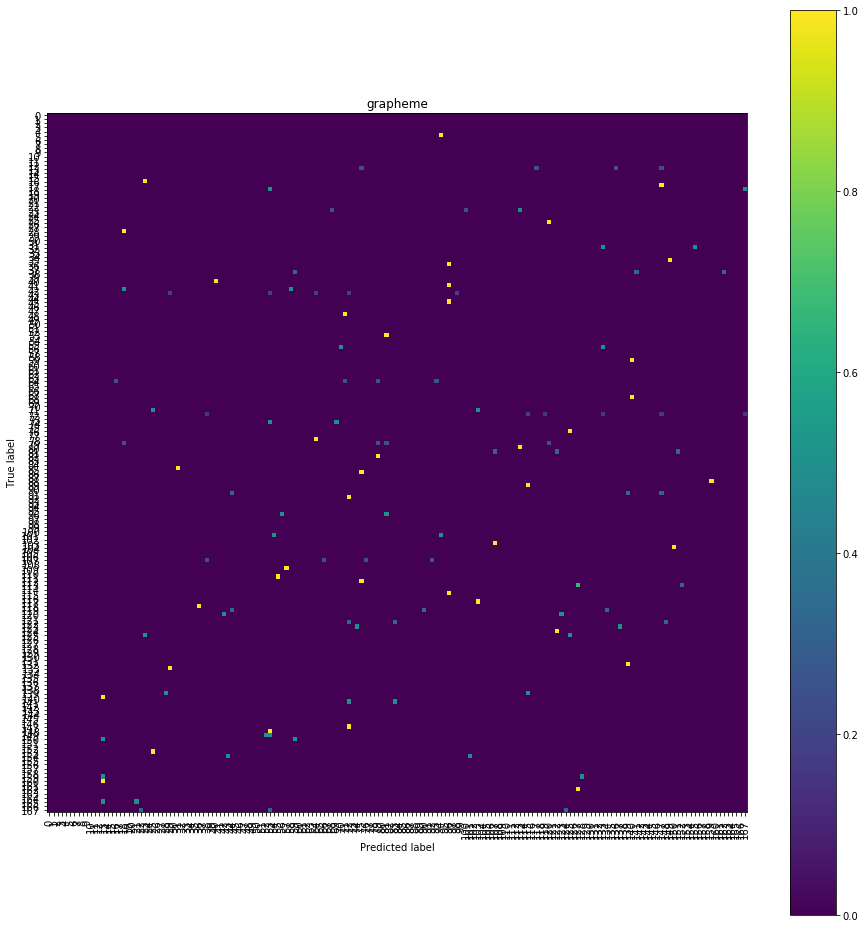

0.1171875


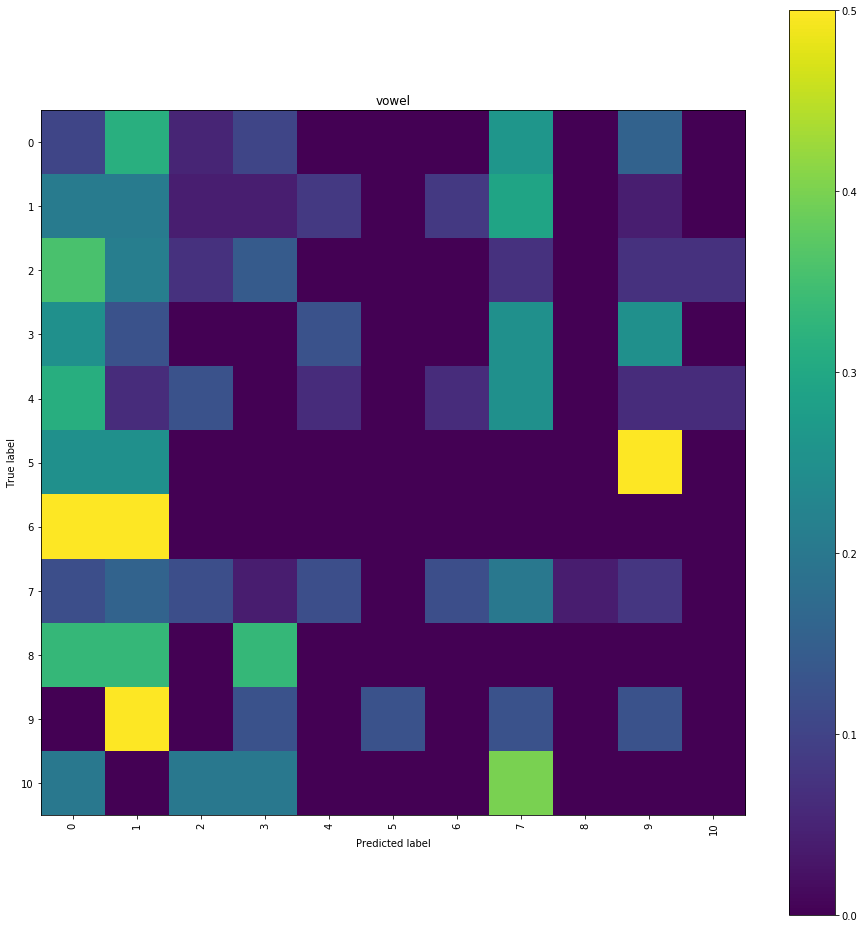

0.4140625


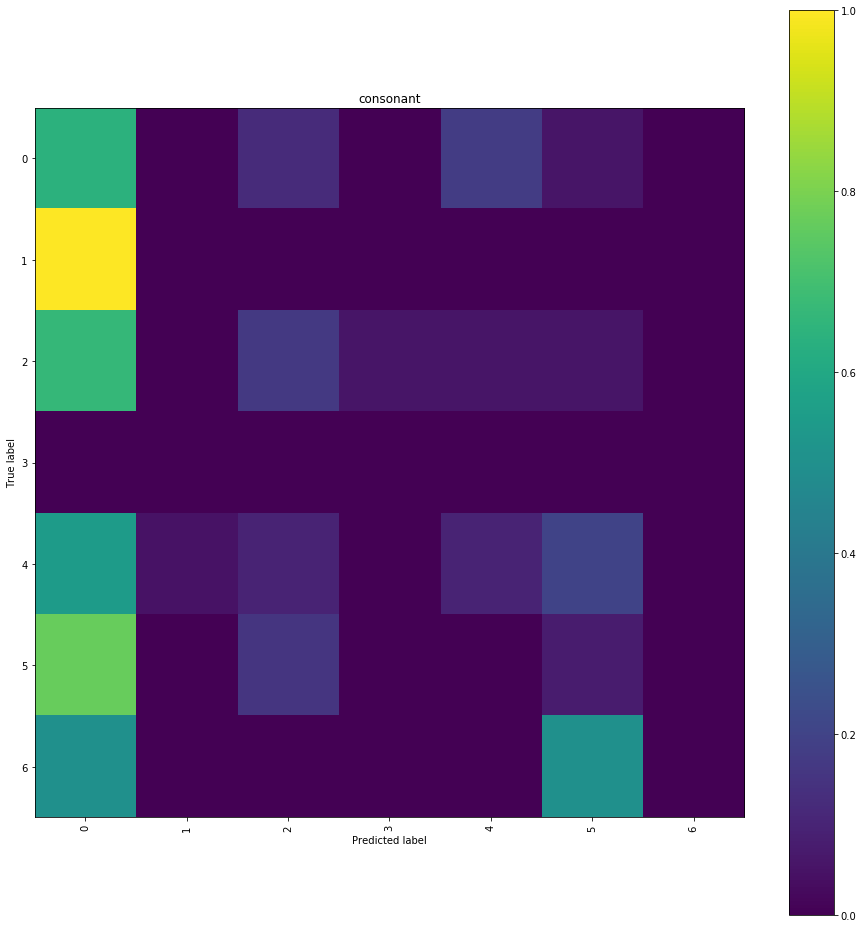

In [122]:
from sklearn.metrics import plot_confusion_matrix
import sklearn
import matplotlib.pyplot as plt 
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay
)

from pylab import rcParams
rcParams['figure.figsize'] = 13, 13

n_classes = [168, 11, 7]

for j,i in enumerate(['grapheme','vowel','consonant']):
    labels = sample['labels'][i+'_labels']
    pred = output[i].max(1, keepdim=True)[1].cpu()

    print(sklearn.metrics.accuracy_score(labels, pred))


    # plt.figure(figsize=(12,12))
    cn_matrix = confusion_matrix(
        y_true=labels.numpy(),
        y_pred=pred,
        labels=list(range(n_classes[j])),
        normalize="true",
    )
    ConfusionMatrixDisplay(cn_matrix, list(range(n_classes[j]))).plot(
        include_values=False, xticks_rotation="vertical"
    )
    plt.title(i)

    plt.tight_layout()
    plt.show()